<a href="https://colab.research.google.com/github/Amir-Kermanshahani/QML/blob/main/Variational_Quantum_Algorithm_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reference** : Learning to learn with quantum neural networks via classical neural networks. Link to article :  https://arxiv.org/abs/1907.05415

Here we focus on an example of VQAs usage, the Quantum Approximate Optimization Algorithm (QAOA) for solving the MaxCut problem.

In [3]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Classical Machine Learning
import tensorflow as tf

tf.get_logger().setLevel("ERROR")

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### Generation of training data: graphs

In our case, we are analyzing MaxCut, which deals with the problem of finding a good binary partition of nodes in a graph such that the number of edges cut by such a separation is maximized.

We start by generating some random graphs G_n,p where:
n is the number of nodes in each graph and
p is the probability of having an edge between two nodes.

In [4]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

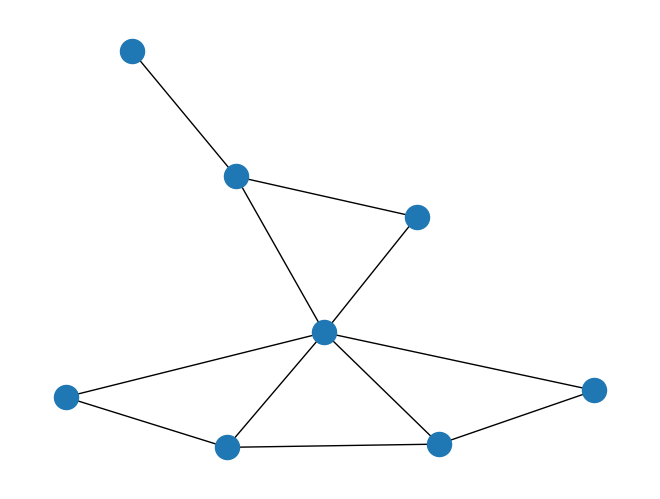

In [16]:
# Define parameters of the graphs
n_graphs = 25
n_nodes = 8
p_edge = 4.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

### Variational Quantum Circuit: QAOA

In [17]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""

    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))

    # Define the structure of the cost and mixer subcircuits for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit.tf", wires=len(graph.nodes))

        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, diff_method="backprop", interface="tf")

        return cost(params)

    return hamiltonian

Example of how to use the above functions

In [19]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just created with some angles.
print(cost(x))

tf.Tensor(-3.087867129996433, shape=(), dtype=float64)


### Recurrent Neural Network: LSTM

We build a custom model of a Long-Short Term Memory (LSTM) network, capable of handling the hybrid data passing between classical and quantum procedures using Keras and TensorFlow.

LSTM cell definition

In [20]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

In [21]:
# We create the QAOA MaxCut cost functions of some graphs (Preprocessing)
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

we seek to reproduce the recurrent behavior by defining two functions:

`rnn_iteration` : accounts for the computations happening on a single time step in the figure. It performs the calculation inside the CPU and evaluates the quantum circuit on the QPU to obtain the loss function for the current parameters.

`recurrent_loop` : as the name suggests, it accounts for the creation of the recurrent loop of the model. In particular, it makes consecutive calls to the rnn_iteration function, where the outputs of a previous call are fed as inputs of the next call.

In [22]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])

    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))

    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]


def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration(
        [initial_cost, initial_params, initial_h, initial_c], graph_cost
    )
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

### Training

Wrapping a single gradient descent step inside a custom function train_step.

In [23]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)

    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

In [24]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/25 - Loss: -1.7233006954193115
 > Graph 6/25 - Loss: -2.2261898517608643
 > Graph 11/25 - Loss: -2.1974921226501465
 > Graph 16/25 - Loss: -2.7451767921447754
 > Graph 21/25 - Loss: -2.744344711303711
 >> Mean Loss during epoch: -2.431381573677063
Epoch 2
 > Graph 1/25 - Loss: -2.1140880584716797
 > Graph 6/25 - Loss: -2.31453275680542
 > Graph 11/25 - Loss: -2.238166093826294
 > Graph 16/25 - Loss: -2.737147092819214
 > Graph 21/25 - Loss: -2.7724556922912598
 >> Mean Loss during epoch: -2.517341866493225
Epoch 3
 > Graph 1/25 - Loss: -2.111337661743164
 > Graph 6/25 - Loss: -2.3173141479492188
 > Graph 11/25 - Loss: -2.2940468788146973
 > Graph 16/25 - Loss: -2.760524272918701
 > Graph 21/25 - Loss: -2.8002562522888184
 >> Mean Loss during epoch: -2.5444977855682374
Epoch 4
 > Graph 1/25 - Loss: -2.11899995803833
 > Graph 6/25 - Loss: -2.318834066390991
 > Graph 11/25 - Loss: -2.3189964294433594
 > Graph 16/25 - Loss: -2.749191999435425
 > Graph 21/25 - Loss: -2.80

### Results

First, we pick a new graph, not present in the training dataset:

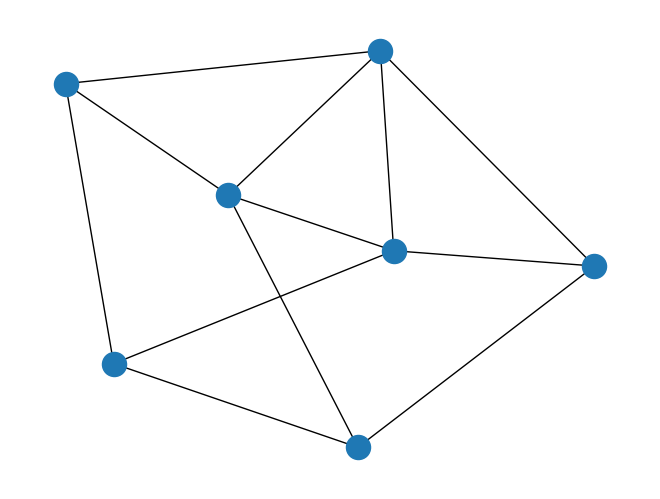

In [25]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

Then we apply the trained RNN to this new graph, saving intermediate results coming from all the recurrent iterations in the network.

In [26]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

Plotting of the loss function

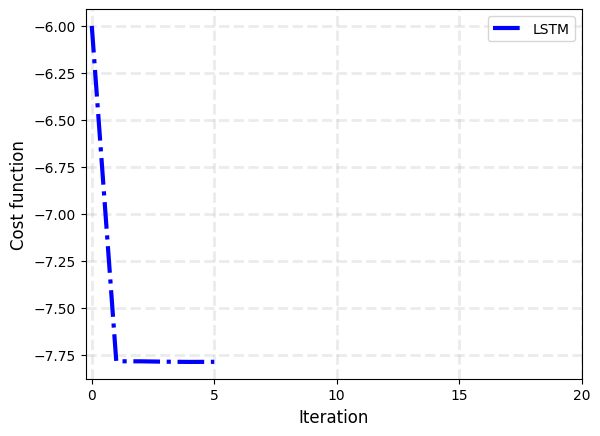

In [27]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20])
plt.show()

### Comparison with standard Stochastic Gradient Descent (SGD)

In [28]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    sdg_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 1 - Loss = -4.248038967473095
Step 2 - Loss = -4.691590912147889
Step 3 - Loss = -5.283298621503665
Step 4 - Loss = -5.960369500817963
Step 5 - Loss = -6.5994153280255095
Step 6 - Loss = -7.089669957933987
Step 7 - Loss = -7.402403626361253
Step 8 - Loss = -7.5773784108865465
Step 9 - Loss = -7.668815348314228
Step 10 - Loss = -7.716034556875802
Step 11 - Loss = -7.741263981847765
Step 12 - Loss = -7.755692097241277
Step 13 - Loss = -7.764674040938583
Step 14 - Loss = -7.77074244856348
Step 15 - Loss = -7.775115997093737
Final cost function: -7.778408706264997
Optimized angles: [[ 0.5902718 ]
 [-0.34612463]]


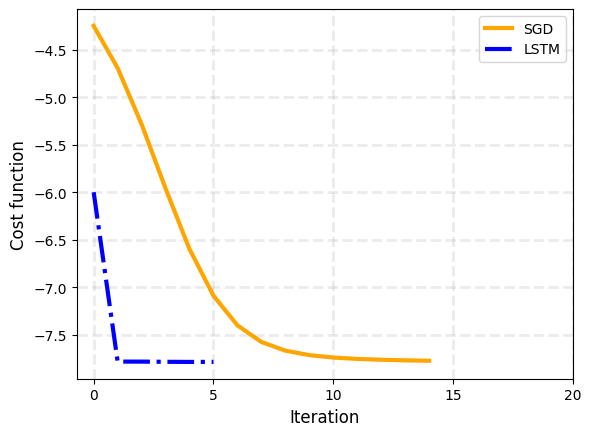

In [29]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20])
plt.show()

As is clear from the picture, the RNN reaches a better minimum in fewer iterations than the standard SGD. Thus, as the authors suggest, the trained RNN can be used for a few iterations at the start of the training procedure to initialize the parameters of the quantum circuit close to an optimal solution. Then, a standard optimizer like the SGD can be used to fine-tune the proposed parameters and reach even better solutions. While on this small scale example the benefits of using an LSTM to initialize parameters may seem modest, on more complicated instances and problems it can make a big difference, since, on random initialization of the parameters, standard local optimizer may encounter problems finding a good minimization direction